In [1]:
from typing import List

from oop_functions.experiment_helper import *
from oop_functions.experiment_runner import ExperimentRunner
from oop_functions.util_functions import *
from oop_functions.visualization_util import *
from oop_functions.analytics_cv_util import *
from oop_functions.analytics_utils import *

%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns

from xgboost import XGBClassifier

import itertools


In [2]:
filesuffix = '_for_experiment_participants_screened_single_first_5_XGBClassifier_cancer_in_next_1_years__15_trials'



Cross-Validation measures:
+--------------------+----------+-------------+----------+----------+
|                    |     mean |         std |      min |      max |
|--------------------+----------+-------------+----------+----------|
| precision__class_0 | 0.999668 | 0.000155429 | 0.999466 | 1        |
| recall__class_0    | 0.996774 | 0.00099326  | 0.994594 | 0.998051 |
| f1-score__class_0  | 0.998219 | 0.000500576 | 0.997095 | 0.998759 |
| precision__class_1 | 0.121286 | 0.0439617   | 0.047619 | 0.194444 |
| recall__class_1    | 0.562963 | 0.203642    | 0.333333 | 1        |
| f1-score__class_1  | 0.197933 | 0.070747    | 0.084507 | 0.311111 |
| accuracy           | 0.996446 | 0.000996703 | 0.994209 | 0.997521 |
| auc                | 0.946339 | 0.0398853   | 0.875323 | 0.999133 |
+--------------------+----------+-------------+----------+----------+


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


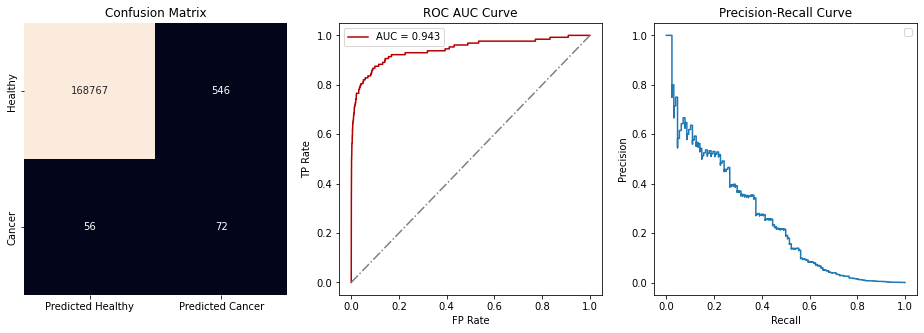

In [3]:
cv_analytics_util = load_cv_analytics_util_see_stats(filesuffix)

In [4]:
id_col = 'index'
label = 'cancer_in_next_1_years'
id_and_confidence = []
for analytics_util in cv_analytics_util.analytics_utils:
    X_test = analytics_util.data_util.test_df[[id_col, 'plco_id', label]]
    X_test_mismatch = X_test.copy()
    y_pred, y_prob = analytics_util.get_predictions() 
    X_test_mismatch[f'{label}_pred'] = y_pred
    X_test_mismatch[f'{label}_prob'] = y_prob
    X_test_mismatch = X_test_mismatch[X_test_mismatch[label] != X_test_mismatch[f'{label}_pred']]
    X_test_mismatch = X_test_mismatch[X_test_mismatch[label] == 1]
    id_and_confidence.append(X_test_mismatch)
mid_conf_predictions_2 = pd.concat(id_and_confidence)

In [6]:
# TODO: include plco_ids and other stuff
mismatches = []
for analytics_util in cv_analytics_util.analytics_utils:
    X_test_mismatch = analytics_util.get_mismatches_neightbors()
    if len(X_test_mismatch) == 0:
        continue
    empty_dict = {col: None for col in X_test_mismatch[0][0].columns}
    for mismatch in X_test_mismatch:
        mismatch_df = pd.concat([*mismatch[:2], pd.DataFrame(empty_dict, index=[0])])
        # mismatch_df.append(empty_dict, ignore_index=True)
        mismatches.append(mismatch_df)

mismatches = pd.concat(mismatches)

In [7]:
mismatches.to_csv('./false_negatives.csv', index=False)

In [8]:
print_df(mismatches)

+-------+-------+------------+-------------+------------+-----------+------------+------------+-----------+-----------+-----------------+----------+-----------+----------+-----------+------------+------------+-------------+-----------------+-----------------+--------------+------------+----------------+-----------------+------------------------+------------+------------+-------------+--------------+-----------+---------------------+------------+-----------+-----------+------------+------------+--------------+--------------+-----------+----------+------------+-----------------+-----------+-------------+--------------+-----------+--------------+------------+------------+--------------+----------+-------------+--------------+------------+-----------+-----------+-----------+-------------+---------+---------------------+-----------+-----------+-----------+-----------------+-----------+------------+-----------+---------------------+------------+-----------+------------+------------+---------

In [9]:
false_negatives = pd.concat(np.array(X_test_mismatch)[:, 0])
false_negatives = false_negatives[false_negatives['cancer_in_next_1_years_prob'] < 0.5]
print_df(false_negatives)

+-------+-------+------------+-------------+-------+---------+-------+------------+-----------+-----------+-----------------+----------+-----------+----------+-----------+------------+------------+-------------+-----------------+-----------------+--------------+------------+----------------+-----------------+------------------------+------------+------------+-------------+---------+-----------+---------------------+-----------+---------+---------+----------+----------+--------------+--------------+---------+----------+------------+-----------------+-----------+-------------+--------------+-----------+--------------+------------+------------+--------------+----------+-------------+--------------+------------+-----------+--------+----------+-------------+---------+---------------------+-----------+-----------+-----------+-----------------+-----------+---------+-----------+---------------------+----------+-----------+------------+------------+-----------+--------------+---------------+---

In [10]:
len(false_negatives)

4

In [11]:
print_df(pd.concat(X_test_mismatch[1][:2]))

+-------+-------+------------+-------------+-------+---------+-------+------------+-----------+-----------+-----------------+----------+-----------+----------+-----------+------------+------------+-------------+-----------------+-----------------+--------------+------------+----------------+-----------------+------------------------+------------+------------+-------------+---------+-----------+---------------------+-----------+---------+---------+----------+----------+--------------+--------------+---------+----------+------------+-----------------+-----------+-------------+--------------+-----------+--------------+------------+------------+--------------+----------+-------------+--------------+------------+-----------+--------+----------+-------------+---------+---------------------+-----------+-----------+-----------+-----------------+-----------+---------+-----------+---------------------+----------+-----------+------------+------------+-----------+--------------+---------------+---

In [12]:
# drop col if the feature value of patient that was misclassified does not appear in the list of feature values of patients that were classified
df = pd.concat(X_test_mismatch[1][:2])
for col in df.columns:
    if df[col].iloc[0] in df[col].iloc[list(range(1, 6))].to_list():
        df.drop(col,inplace=True,axis=1)
print_df(df)
summary = summarize_features(df)

+-------+---------+----------+-----------+----------+------------+-----------------+------------+-------------+---------+------------+------------+-------------+-----------+-----------+-----------+---------+-----------+------------+---------------+--------------+--------------+---------------+-------------+--------------+---------------+----------------+----------------+-----------------+----------------+-----------------+--------------+---------------+--------------+---------------+--------------+---------+------------+----------+---------+-----------+--------------+---------------+----------+--------------+------------+--------------------------+-------------------------------+-------------------------------+------------+
|       |   asppd |   bmi_20 |   bmi_20c |   bmi_50 |   bmi_curr |   ca125ii_level |   cig_stop |   cig_years |    echo |   hearta_f |   height_f |   lantero_p |   llong_p |   lmenstr |   ltran_p |   maxdi |   numcyst |   numcystl |   ovar_result |   ovariesr_f |   

In [14]:

df = pd.concat(X_test_mismatch[3][:2])
for col in df.columns:
    if len(df[col].unique()) <= 2:
        df.drop(col,inplace=True,axis=1)
print_df(df)
summary = summarize_features(df)
print_df(summary)

+-------+-----------+----------+----------+------------+-----------------+------------+-----------------+---------+---------+-----------+------------+-------------+---------+-----------+-----------+----------+---------------+--------------+---------------+---------------+-------------+--------------+--------------+---------------+----------------+----------------+------------------+-------------------+--------------+---------------+---------------+---------+---------+-------------+-----------+-----------+-----------+----------+---------+-----------+--------------+-----------+--------------+--------------+------------+------------+
|       |   bcontrt |   bmi_20 |   bmi_50 |   bmi_curr |   breast_fh_age |   brothers |   ca125ii_level |    cyst |    echo |   fmenstr |   height_f |   lantero_p |   livec |   llong_p |   ltran_p |    maxdi |   ovar_result |   ovary_diam |   ovary_diaml |   ovary_diamr |   ovary_vol |   ovary_voll |   ovary_volr |   ovcyst_diam |   ovcyst_diaml |   ovcyst_di